## Chocolate Classification using DL

#### Imports:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import cv2
import shutil
from shutil import copyfile
import random

import keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # from keras.preprocessing.image import ImageDataGenerator is deprecated
from sklearn.model_selection import train_test_split
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Plot history:

In [1]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Setting up the data:

In [18]:
train_dir = '../Dataset/train/'
test_dir = '../Dataset/test/'

In [44]:
# show the number of images in each class
for i in os.listdir(train_dir):
    print(f'{i}: {len(os.listdir(train_dir + i))}')

# show the number of images in each class
for i in os.listdir(test_dir):
    print(f'{i}: {len(os.listdir(test_dir + i))}')

dark: 47
white: 42
dark: 19
white: 17


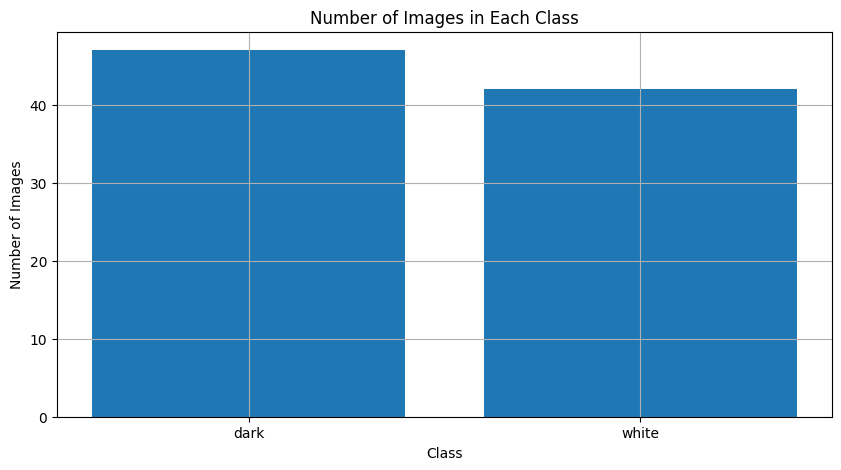

In [46]:
# plot the bar chart
plt.figure(figsize=(10, 5))
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.bar(os.listdir(train_dir), [len(os.listdir(train_dir + i)) for i in os.listdir(train_dir)])
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [19]:
#use generators
#resize image
train_ds = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 89 files belonging to 2 classes.
Found 36 files belonging to 2 classes.


In [20]:
def process(image, label):
    image = tf.cast(image/255,tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

#### Approach 1: CNN

In [21]:
# Model Definition
INPUT_SHAPE = (256, 256, 3)

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), input_shape = INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))


In [22]:
model.compile(loss='binary_crossentropy',
             optimizer='Adam',
             metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 activation_10 (Activation)  (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 activation_11 (Activation)  (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                 

In [24]:
history = model.fit(train_ds,
                  batch_size = 32,
                  verbose=1,
                  epochs=20,
                  validation_data=validation_ds,
                  shuffle=False)

Epoch 1/20


2023-07-21 18:19:20.569178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-21 18:19:20.581341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


3/3 [==============================] - 3s 714ms/step - loss: 2.7618 - accuracy: 0.4944 - val_loss: 0.8593 - val_accuracy: 0.4722


2023-07-21 18:19:22.720849: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto
2023-07-21 18:19:22.725136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


Epoch 2/20
3/3 [==============================] - 1s 170ms/step - loss: 0.8974 - accuracy: 0.5843 - val_loss: 0.6965 - val_accuracy: 0.4722
Epoch 3/20
3/3 [==============================] - 1s 160ms/step - loss: 0.6851 - accuracy: 0.5281 - val_loss: 0.7436 - val_accuracy: 0.5278
Epoch 4/20
3/3 [==============================] - 1s 155ms/step - loss: 0.7008 - accuracy: 0.5843 - val_loss: 0.6546 - val_accuracy: 0.6944
Epoch 5/20
3/3 [==============================] - 1s 154ms/step - loss: 0.6097 - accuracy: 0.7191 - val_loss: 0.6140 - val_accuracy: 0.7778
Epoch 6/20
3/3 [==============================] - 1s 154ms/step - loss: 0.5237 - accuracy: 0.7528 - val_loss: 0.5717 - val_accuracy: 0.7222
Epoch 7/20
3/3 [==============================] - 1s 159ms/step - loss: 0.5058 - accuracy: 0.7303 - val_loss: 0.5536 - val_accuracy: 0.9167
Epoch 8/20
3/3 [==============================] - 1s 155ms/step - loss: 0.4442 - accuracy: 0.8652 - val_loss: 0.4595 - val_accuracy: 0.8611
Epoch 9/20
3/3 [====

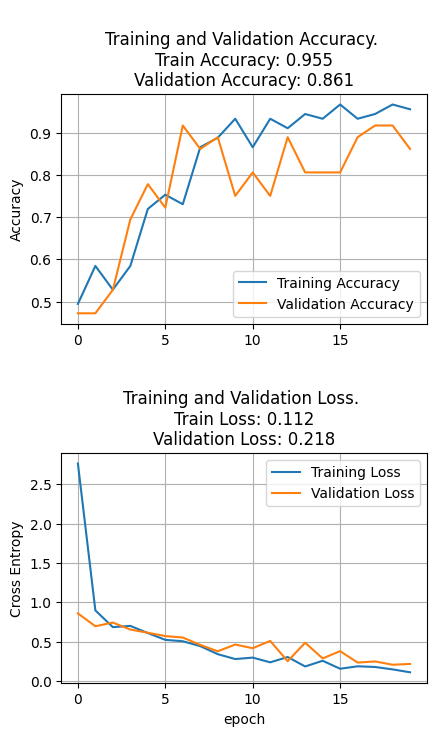

In [25]:
plot_history(history)

In [26]:
_, acc = model.evaluate(validation_ds)
print("Accuracy: ", (acc*100.0), " %")

2/2 [==============================] - 0s 13ms/step - loss: 0.2178 - accuracy: 0.8611
Accuracy:  86.11111044883728  %


#### Approach 2: VGG16

In [27]:
# Load the pre-trained VGG19 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: cat and dog

In [28]:
# Create the final model
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [30]:
vgg16_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [32]:
# Train the model
history = vgg16_model.fit(train_ds,
                       epochs=25,
                       validation_data=validation_ds,
                       verbose=1)

Epoch 1/25
3/3 [==============================] - 3s 934ms/step - loss: 0.0423 - accuracy: 0.9888 - val_loss: 1.4054 - val_accuracy: 0.7222
Epoch 2/25
3/3 [==============================] - 3s 909ms/step - loss: 1.0408e-04 - accuracy: 1.0000 - val_loss: 1.2944 - val_accuracy: 0.7222
Epoch 3/25
3/3 [==============================] - 3s 906ms/step - loss: 3.5044e-04 - accuracy: 1.0000 - val_loss: 1.2744 - val_accuracy: 0.6944
Epoch 4/25
3/3 [==============================] - 3s 914ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.2882 - val_accuracy: 0.6944
Epoch 5/25
3/3 [==============================] - 3s 929ms/step - loss: 2.5469e-04 - accuracy: 1.0000 - val_loss: 1.3003 - val_accuracy: 0.6944
Epoch 6/25
3/3 [==============================] - 3s 934ms/step - loss: 2.3039e-04 - accuracy: 1.0000 - val_loss: 1.3113 - val_accuracy: 0.6944
Epoch 7/25
3/3 [==============================] - 3s 942ms/step - loss: 8.3880e-05 - accuracy: 1.0000 - val_loss: 1.3215 - val_accuracy: 0.7222


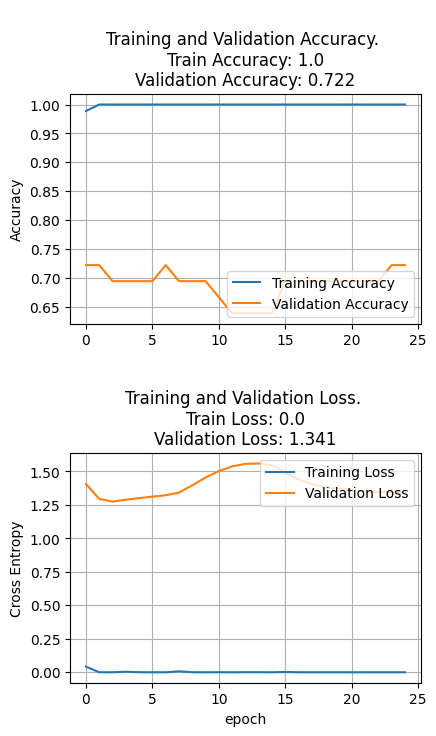

In [33]:
plot_history(history)

#### Approach 3: ResNet50

In [34]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False
# Add custom classification layers on top of the pre-trained model
last_output = base_model.output 
x = tf.keras.layers.Flatten()(last_output)  # Flatten the output layer to 1 dimension
x = tf.keras.layers.Dense(1024, activation='relu')(x)   # Add a fully connected layer with 1024 hidden units and ReLU activation
x = tf.keras.layers.Dropout(0.6)(x) # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # 2 classes: cats and dogs

In [35]:
# create the final model
resnet50_model = Model(inputs=base_model.input, outputs=predictions)
resnet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [36]:
resnet50_model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
            loss = 'binary_crossentropy',
            metrics=['accuracy'])

In [37]:
# Train the model
resnet50_history = model.fit(train_ds,
                       epochs=20,
                       validation_data=validation_ds,
                       verbose=1)

Epoch 1/20
3/3 [==============================] - 1s 279ms/step - loss: 0.0925 - accuracy: 0.9663 - val_loss: 0.2115 - val_accuracy: 0.9167
Epoch 2/20
3/3 [==============================] - 1s 172ms/step - loss: 0.1013 - accuracy: 0.9775 - val_loss: 0.1943 - val_accuracy: 0.9167
Epoch 3/20
3/3 [==============================] - 1s 162ms/step - loss: 0.0910 - accuracy: 0.9888 - val_loss: 0.2876 - val_accuracy: 0.9167
Epoch 4/20
3/3 [==============================] - 1s 162ms/step - loss: 0.1196 - accuracy: 0.9438 - val_loss: 0.1960 - val_accuracy: 0.9167
Epoch 5/20
3/3 [==============================] - 1s 163ms/step - loss: 0.0683 - accuracy: 0.9888 - val_loss: 0.3569 - val_accuracy: 0.8333
Epoch 6/20
3/3 [==============================] - 1s 162ms/step - loss: 0.1348 - accuracy: 0.9551 - val_loss: 0.2095 - val_accuracy: 0.9167
Epoch 7/20
3/3 [==============================] - 1s 162ms/step - loss: 0.0732 - accuracy: 0.9888 - val_loss: 0.2954 - val_accuracy: 0.8611
Epoch 8/20
3/3 [====

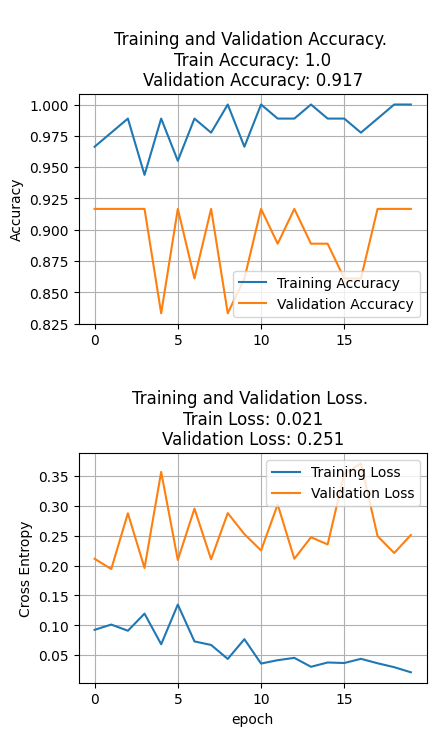

In [38]:
plot_history(resnet50_history)

#### 4. CNN with Attention mechanism

In [2]:
# importing modules and libraries

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, Flatten, ELU, Dense, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Nadam

In [3]:
# Checking extension appropriateness: allowed extensions: .jpg, .jpeg, .png

from pathlib import Path
import imghdr

data_dir = "..\Dataset\Chocolate Classification"
image_extensions = [".png", ".jpg"]  # specific filetypes to be focused on for checking

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"] # Keras only allows following extensions for data loading currently
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image") # if there is no file type, we throw error for such a file
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow") # in case a file type is found to be not consistent with appropriate extensions list

C:\Users\ariha\AppData\Local\Temp\ipykernel_3824\938651792.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


..\Dataset\Chocolate Classification\Dark Chocolate\Image_140.jpg is a webp, not accepted by TensorFlow
..\Dataset\Chocolate Classification\White Chocolate\Image_10.jpg is a webp, not accepted by TensorFlow
..\Dataset\Chocolate Classification\White Chocolate\Image_56.jpg is a webp, not accepted by TensorFlow


In [4]:
import os

dataset_dir = '..\Dataset\Chocolate Classification'

extensions = [".png", ".jpg", ".jpeg"] # focused extensions

images_list = [] # stores images
labels_list = [] # stores labels

image_size = (64, 64) # image resizing specification

for folder_name in os.listdir(dataset_dir): # iterating into file
    folder_path = os.path.join(dataset_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path): # check image, take out file extension, check extension
            file_path = os.path.join(folder_path, file_name)
            if file_name.lower().endswith(tuple(extensions)):
                actual_format = imghdr.what(file_path) # true file extension
                if actual_format == 'webp':
                    continue

                image_data = tf.io.read_file(file_path) # reading images
                image = tf.image.decode_jpeg(image_data, channels=3) # turning into RGB .jpeg format

                image = tf.image.resize(image, image_size) # resizing image to criteria

                image = tf.cast(image / 255.0, tf.float32) # normalizing image

                label = folder_name # finding labels

                images_list.append(image.numpy()) # appending labels and images
                labels_list.append(label)

images = np.array(images_list) # turning labels and images  lists' into arrays
labels = np.array(labels_list)

In [5]:
# encoding image labels

from sklearn.preprocessing import OrdinalEncoder 

encoder = OrdinalEncoder()

labels = encoder.fit_transform(labels.reshape(-1, 1))

In [6]:
# Data Splitting

from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(images,labels,test_size=0.5,random_state=42)

x_test, x_val, y_test, y_val = train_test_split(x_temp,y_temp,test_size=0.5)

# train:val:test ratio : 50:25:25

# shapes of data
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

x_train: (67, 64, 64, 3)
y_train: (67, 1)
x_test: (33, 64, 64, 3)
y_test: (33, 1)
x_val: (34, 64, 64, 3)
y_val: (34, 1)


In [109]:
from keras.models import Model
from keras.layers import Multiply
from keras.regularizers import l2

def attention_mechanism(inputs): # Attention mechanism

    att_weights = Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(inputs)

    attended_output = Multiply()([inputs, att_weights])
    
    return attended_output

# MOdel Checkpoint focused on val_accuracy to store best weights of max val_accuracy
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')

input_dim = Input(shape=(64, 64, 3)) # input layer

# Convolutional layers with BatchNormalization and MaxPooling
layer_1 = Conv2D(32, 3, activation=ELU(), padding='same', kernel_initializer = 'he_uniform')(input_dim)
x = BatchNormalization()(layer_1)
x = MaxPooling2D(pool_size=2, padding='same')(x)

x = attention_mechanism(x)

# regularized convolutional layer
layer_2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer = 'he_uniform', kernel_regularizer=l2(0.01))(x)
layer_2 = BatchNormalization()(layer_2)
x = MaxPooling2D(pool_size=2, padding='same')(layer_2)

x = attention_mechanism(x)

# Flatten layer to reshape data
x = Flatten()(x)

# Dense layers
layer_4 = Dense(32, activation='relu', kernel_regularizer=l2(0.009))(x)

# output layer
layer_5 = Dense(1, activation='sigmoid')(layer_4)

model = Model(inputs=input_dim, outputs=layer_5) # setting model layers
model.summary() # summary of model

model.compile(optimizer=Nadam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy']) # compiling the model

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 64, 64,    │        896 │ input_layer_19[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_38    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 32, 32, 1) │         33 │ max_pooling2d_38… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_38         │ (None, 32, 32,    │          0 │ max_pooling2d_38… │
│ (Multiply)          │ 32)               │            │ conv2d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 32, 32,    │      9,248 │ multiply_38[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_39    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 16, 16, 1) │         33 │ max_pooling2d_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_39         │ (None, 16, 16,    │          0 │ max_pooling2d_39… │
│ (Multiply)          │ 32)               │            │ conv2d_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 8192)      │          0 │ multiply_39[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 32)        │    262,176 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 1)         │         33 │ dense_38[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 272,675 (1.04 MB)

 Trainable params: 272,547 (1.04 MB)

 Non-trainable params: 128 (512.00 B)

In [110]:
# training model
history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=25, callbacks=[model_checkpoint],verbose=1,batch_size=5)

Epoch 1/25
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7367 - loss: 1.7231
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.7499 - loss: 1.7103 - val_accuracy: 0.5000 - val_loss: 2.0218
Epoch 2/25
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9793 - loss: 1.2049
Epoch 2: val_accuracy did not improve from 0.50000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9781 - loss: 1.2042 - val_accuracy: 0.5000 - val_loss: 2.1030
Epoch 3/25
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9950 - loss: 1.1163
Epoch 3: val_accuracy improved from 0.50000 to 0.58824, saving model to model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9916 - loss: 1.1205 - val_accuracy: 0.5882 - val_loss: 1.8120
Epoch 4/25
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9819 - loss: 1.0655
Epoch 4: val_accuracy improved from 0.58824 to 0.76471, saving model to model.keras
14/14 ━━━━━

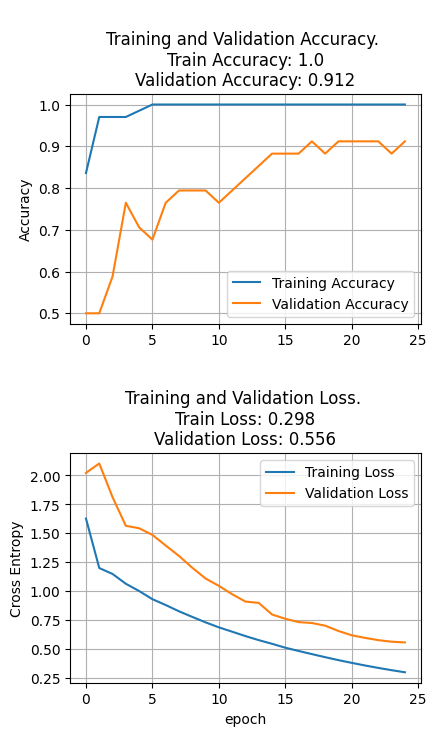

In [111]:
plot_history(history) # plotting graphs through function

In [112]:
y_pred = model.predict(x_test) # predicting on actual model
y_pred_binary = (y_pred > 0.5).astype(int) # converting predictions into labels

# Metrics

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Accuracy
accuracy = accuracy_score(y_test,y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test,y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test,y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,y_pred_binary)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test,y_pred_binary)
auc = roc_auc_score(y_test,y_pred_binary)
print("AUC:", auc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Accuracy: 0.9696969696969697
Precision: 0.9090909090909091
Recall: 1.0
F1 Score: 0.9523809523809523
Confusion Matrix:
 [[22  1]
 [ 0 10]]
AUC: 0.9782608695652174


In [113]:
model.evaluate(x_test,y_test) # evluating on actual model

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9694 - loss: 0.3882


[0.3878534436225891, 0.9696969985961914]

In [114]:
# loading best model

import keras

model1 = keras.models.load_model('model.keras', custom_objects={"ELU": keras.layers.ELU}) # loading saved model

# testing best model, with metrics

y_pred = model1.predict(x_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test,y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test,y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test,y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,y_pred_binary)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test,y_pred_binary)
auc = roc_auc_score(y_test,y_pred_binary)
print("AUC:", auc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Accuracy: 0.9696969696969697
Precision: 0.9090909090909091
Recall: 1.0
F1 Score: 0.9523809523809523
Confusion Matrix:
 [[22  1]
 [ 0 10]]
AUC: 0.9782608695652174


In [115]:
model1.evaluate(x_test,y_test) # evaluating on best model

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9694 - loss: 0.5682 


[0.569284975528717, 0.9696969985961914]

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 1.0\nValidation Accuracy: 0.912')

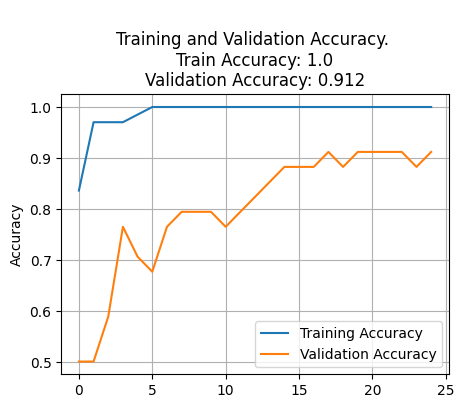

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(5, 8))
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    